In [1]:
import os
import numpy as np
import keras
from keras.applications import ResNet50V2
from keras import models
from keras.layers import LSTM, Dense, Activation, Dropout, BatchNormalization, GlobalAveragePooling1D
from keras import layers
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import optimizers
import matplotlib.pyplot as plt
import cv2
from keras.layers import Dropout
from tensorflow.keras import backend as K
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import csv
import pandas as pd

Using TensorFlow backend.
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\idong\Anaconda3\envs\tens_gpu

# Plan

   - ### DATA
   
       1) time을 안 가져왔을 때
       
          - 여러개의 데이터를 묶을 수 없음(각각의 묶음 데이터끼리 이어지면 안 됨)
             -> 한 묶음씩 데이터를 학습해야 함.
             -> n개의 묶음이 있다면 n번 학습시켜야 함.
          
          - 모델이 가벼움
          
          - 하루동안 전체적인 모습을 보며 학습할 수도 있음
      
      
    2) time을 가져왔을 때
          
      - 여러개의 데이터를 묶어서 한번에 학습시킬 수 있음 (time 데이터가 있으니 구별이 됨.
           
      - 시간데이터까지 보게하려면 layer들이 heavy해질 수 있음
      
      - 예측은 더 잘 할 수도 있음

## data와 label 불러오기

In [32]:
prices_data = np.load(r'D:\dataset\stoke\total_data\samsung_data.npy')
label = np.load(r'D:\dataset\stoke\total_data\samsung_label.npy')

## data

   - 일단 price data만
   - 추후 time이나 sell, buy value 추가 예정

## Normalization data

   1. Z-normalization
   
   2. mean-max normalization

### Z-normalization

### mean-max normalization

## Create Windows

   - hyperparameter : seq_len

     -> 50개의 데이터를 보고 추후 라벨을 예측함 (50개씩 묶음)
     
     -> label도 앞의 49개는 지워줘야 함 (data 보다 원래 1개 적기 때문에)


In [22]:
prices_data= prices_data[:, :, np.newaxis]

# Make data_set

   - data split
   
   - label one hot incoding

In [33]:
train_data, val_data, train_label, val_label = train_test_split(prices_data, label, test_size = 0.1, random_state = 123)

In [34]:
train_data.shape

(2565, 5, 5)

In [35]:
val_data.shape

(286, 5, 5)

- ### 원핫인코딩을 위한 전처리

In [37]:
one_hot_train_labels = to_categorical(train_label)
one_hot_validation_labels = to_categorical(val_label)

## Model

In [57]:
model = models.Sequential()

model.add(LSTM(256, return_sequences=True, input_shape=(5, 5)))
model.add(BatchNormalization())
model.add(LSTM(128, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization()) 
model.add(LSTM(32, return_sequences=False))


model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 5, 256)            268288    
_________________________________________________________________
batch_normalization_22 (Batc (None, 5, 256)            1024      
_________________________________________________________________
lstm_30 (LSTM)               (None, 5, 128)            197120    
_________________________________________________________________
batch_normalization_23 (Batc (None, 5, 128)            512       
_________________________________________________________________
lstm_31 (LSTM)               (None, 5, 64)             49408     
_________________________________________________________________
batch_normalization_24 (Batc (None, 5, 64)             256       
_________________________________________________________________
lstm_32 (LSTM)               (None, 32)               

In [58]:
model.compile(optimizer=optimizers.Adam(1e-6),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [59]:
'''    keras.callbacks.EarlyStopping(
        monitor='acc',
        patience = 14,
        mode = max
    ),'''
callbacks_stoke = [

    keras.callbacks.ModelCheckpoint(
        filepath='stoke_parameter5_3.h5',
        monitor='val_acc',
        save_best_only=False,
        period = 1
    ),
    keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 10
    )
]

## 첫번째 학습결과

In [60]:
history = model.fit(
    train_data, one_hot_train_labels,
    batch_size = 502,
    epochs = 550,
    callbacks= callbacks_stoke,
    validation_data=(val_data, one_hot_validation_labels)
)

Train on 2565 samples, validate on 286 samples
Epoch 1/550
2565/2565 [==============================] - 2s 965us/step - loss: 1.1006 - acc: 0.3037 - val_loss: 1.0986 - val_acc: 0.4231
Epoch 2/550
2565/2565 [==============================] - 0s 103us/step - loss: 1.0991 - acc: 0.3228 - val_loss: 1.0985 - val_acc: 0.4685
Epoch 3/550
2565/2565 [==============================] - 0s 100us/step - loss: 1.1007 - acc: 0.3068 - val_loss: 1.0984 - val_acc: 0.4685
Epoch 4/550
2565/2565 [==============================] - 0s 100us/step - loss: 1.0994 - acc: 0.3154 - val_loss: 1.0984 - val_acc: 0.4930
Epoch 5/550
2565/2565 [==============================] - 0s 103us/step - loss: 1.0998 - acc: 0.3224 - val_loss: 1.0983 - val_acc: 0.5175
Epoch 6/550
2565/2565 [==============================] - 0s 100us/step - loss: 1.1000 - acc: 0.3283 - val_loss: 1.0982 - val_acc: 0.5280
Epoch 7/550
2565/2565 [==============================] - 0s 95us/step - loss: 1.0991 - acc: 0.3322 - val_loss: 1.0982 - val_acc: 0.

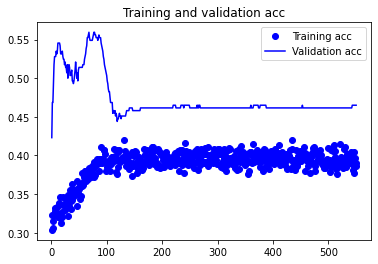

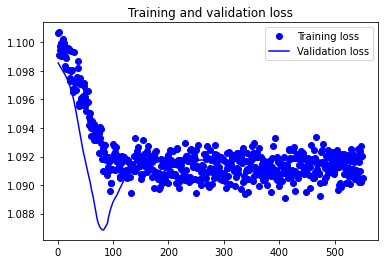

In [61]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 50분, price & volumn

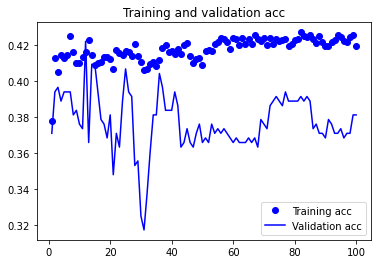

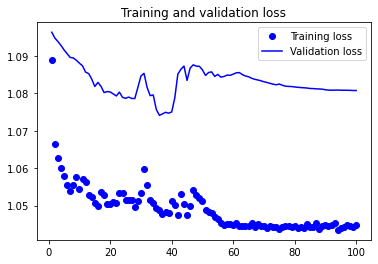

In [72]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 10분, price, volumn

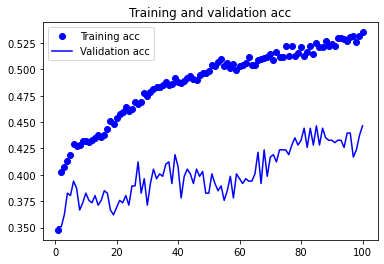

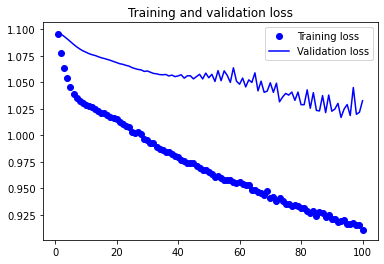

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 10분, price, volumn, 전일비 상승값

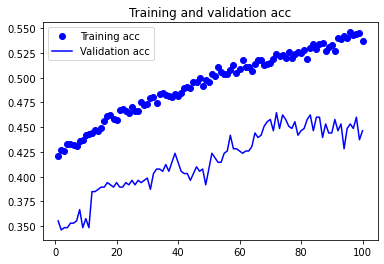

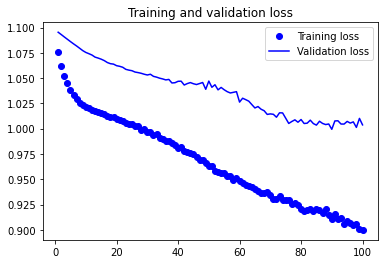

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 5분, price, volumn, 전일비 상승값

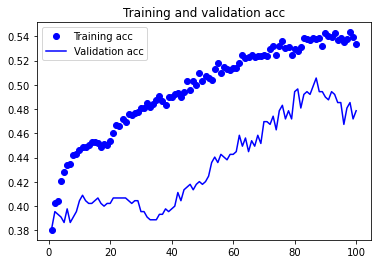

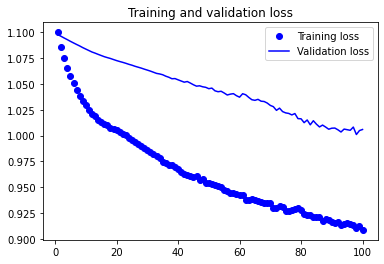

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

---

In [35]:
model = models.load_model('stoke3_test_1.h5')
model.load_weights('stoke3_test_1.h5')

In [36]:
callbacks_stoke_oil = [
    keras.callbacks.ModelCheckpoint(
        filepath='stoke3_test_2.h5',
        monitor='val_acc',
        save_best_only=True,
        period = 1
    ),
    keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 10
    )
]

In [37]:
history = model.fit(
    train_data, one_hot_train_labels,
    batch_size = 502,
    epochs = 100,
    callbacks= callbacks_stoke_oil,
    validation_data=(val_data, one_hot_validation_labels)
)

Train on 4001 samples, validate on 445 samples
Epoch 1/100
4001/4001 [==============================] - 1s 374us/step - loss: 0.9112 - acc: 0.5381 - val_loss: 1.0047 - val_acc: 0.4899
Epoch 2/100
4001/4001 [==============================] - 0s 48us/step - loss: 0.9076 - acc: 0.5461 - val_loss: 0.9975 - val_acc: 0.4876
Epoch 3/100
4001/4001 [==============================] - 0s 47us/step - loss: 0.9085 - acc: 0.5401 - val_loss: 1.0037 - val_acc: 0.4899
Epoch 4/100
4001/4001 [==============================] - 0s 47us/step - loss: 0.9050 - acc: 0.5431 - val_loss: 1.0000 - val_acc: 0.4831
Epoch 5/100
4001/4001 [==============================] - 0s 47us/step - loss: 0.9045 - acc: 0.5416 - val_loss: 0.9998 - val_acc: 0.4899
Epoch 6/100
4001/4001 [==============================] - 0s 48us/step - loss: 0.9040 - acc: 0.5456 - val_loss: 1.0012 - val_acc: 0.4831
Epoch 7/100
4001/4001 [==============================] - 0s 48us/step - loss: 0.9063 - acc: 0.5419 - val_loss: 0.9997 - val_acc: 0.4787


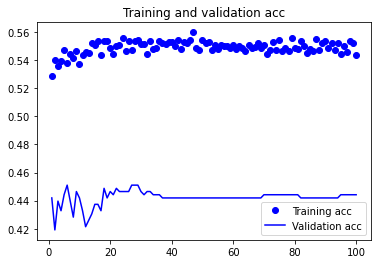

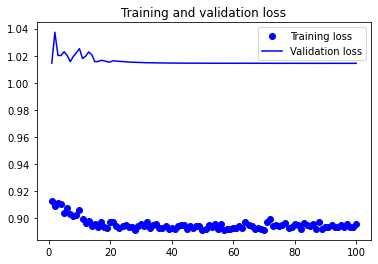

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

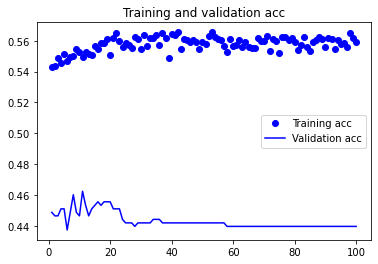

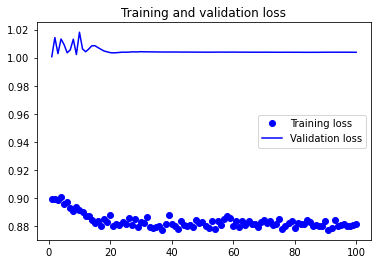

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

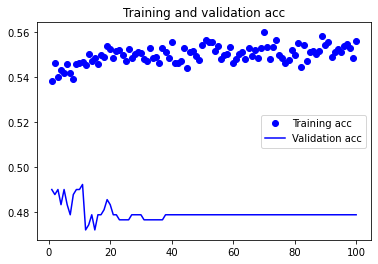

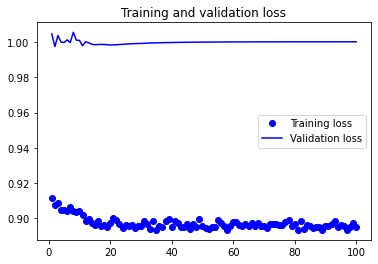

In [38]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()